## Evaluating layer-wise sources and sinks of o2 using wmt

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import budgetcalcs as bc
import rebin_functions as rb
from xhistogram.xarray import histogram
from xarrayutils import vertical_coordinates as vc

In [3]:
# Load the data
rootdir = '/archive/gam/ESM4/DECK/ESM4_piControl_D/gfdl.ncrc4-intel16-prod-openmp/'
runname = '6'
filename = '08990101.ocean_month.nc'
ds = xr.open_dataset(rootdir+runname+'/history/'+filename).isel(time=0)
filename_grid = '08990101.ocean_static_no_mask_table.nc'
grid = xr.open_dataset(rootdir+runname+'/history/'+filename_grid)
# Grab rho2 interfaces from model output
runname=''
filename_rho2 = '08990101.ocean_month_rho2.nc'
rho2_i = xr.open_dataset(rootdir+runname+'/history/'+filename_rho2).rho2_i
rho2_l = xr.open_dataset(rootdir+runname+'/history/'+filename_rho2).rho2_l
# Name of vertical coordinate
vertc = 'zl'
rho0=ds['rhozero'].values
cp=ds['cpocean'].values

# SET EVERYTHING WITH ZERO THICKNESS TO NAN
# ds = ds.where(ds['thkcello']>0.001,np.nan)

# Budgets
heat_terms = ['opottemptend','T_advection_xy','Th_tendency_vert_remap','boundary_forcing_heat_tendency','internal_heat_heat_tendency','opottempdiff','opottemppmdiff','frazil_heat_tendency']
salt_terms = ['osalttend','S_advection_xy','Sh_tendency_vert_remap','boundary_forcing_salt_tendency','osaltdiff','osaltpmdiff']
o2_terms = ['o2h_tendency','o2_advection_xy','o2h_tendency_vert_remap','o2_dfxy_cont_tendency','o2_vdiffuse_impl','jo2']

# Close oxygen budget
o2_tend = o2_terms[0]
# Correct MOM6 tendencies to account for mass in cell
# i.e. convert from [mol kg^-1 m s^-1] to [mol m^-2 s^-1]
for term in o2_terms[:-1]:
    ds[term] *= rho0
    
### THIS A HACK WHILE I WORK OUT THE VDIFFUSE_IMPL TERMS ###
# Calculate residual error
# OXYGEN
tendsum,error = bc.calc_budget(ds,o2_terms[1:],o2_terms[0],plot=False)
ds['o2_vdiffuse_impl']=error

# # SALT
# tendsum,error = bc.calc_budget(ds,salt_terms[1:],salt_terms[0],plot=True)
# ds['osaltdiff']=ds['osaltdiff']+error


/nbhome/gam/miniconda/envs/mom6/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


In [4]:
# Prepare for water mass transformation calculations
# Calculate material derivative and diffusive terms
signsLHS = [-1,1,1]
signsRHS = [1,1,1,1,1]
# HEAT
termsLHS = heat_terms[:3]
termsRHS = heat_terms[3:]
Dheat, dheat, error_heat = bc.calc_materialderivative(ds,termsLHS,signsLHS,termsRHS,signsRHS,plot=False)
# SALT
signsLHS = [-1,1,1]
signsRHS = [1,1,1]
termsLHS = salt_terms[:3]
termsRHS = salt_terms[3:]
Dsalt, dsalt, error_salt = bc.calc_materialderivative(ds,termsLHS,signsLHS,termsRHS,signsRHS,plot=False)
# RHO
Dheat = -1*Dheat
Dsalt = -1*Dsalt

drho = (ds['drho_dT']/cp)*dheat+(ds['drho_dS']*ds['salt'])*dsalt

In [5]:
def calc_E(ds,l,l_i_vals,dl,c,area,z='depth',xdim='xh',ydim='yh',zldim='zl',zidim='zi',binning=None):
    '''Evaluation of the transport of tracer [c] across contours of tracer [l]
    l and c should be given as strings and both be contained in Dataset ds
    dl corresponds to the diffusive time tendency of tracer *content* of l,
    i.e. the tendency of rho*l*h where h is layer thickness, and rho is in situ
    density, thus in units of [kg m^-3]*[l tracer unit]*[m]*[s-1].
    Then
        E(l') = \frac{1}{\Delta l}\iint_{l=l'} c*dl dA
    This uses the fact that the tracer content tendency is equal to the 
    rho * tracer tendency integrated within a layer (which is formulation for
    wmt in Groeskamp et al, 2019).'''
    
    E = xr.Dataset()
    
    # Calculate tracer at layer centres from interface values
    l_l_vals = 0.5*(l_i_vals[:-1]+l_i_vals[1:])
    # Calculate delta_tracer for each layer
    delta_l_vals = np.diff(l_i_vals)
    # Place in DataArrays
    l_i=xr.DataArray(l_i_vals,dims=['l_i'],coords={'l_i':l_i_vals})
    l_l=xr.DataArray(l_l_vals,dims=['l_l'],coords={'l_l':l_l_vals})
    delta_l = xr.DataArray(delta_l_vals,dims=['l_l'],coords={'l_l':l_l_vals})

    # Calculate cdl
    cdl = ds[c]*dl

    # Bin into layers of l, and sum up across space
    if binning is None:
        work = (cdl*area).sum(dim=[xdim,ydim])
        work = work.rename({vertc:'l_l'})
    if binning=='xhistogram':
        nanmask = np.isnan(cdl)
        work = histogram(
                    ds[l].where(~nanmask), 
                    bins=[l_i.values], 
                    dim=['xh','yh','zl'], 
                    weights=(cdl*area).where(~nanmask),
                    block_size=None
                    )
        work = work.rename({l+'_bin':'l_l'})
    if binning=='busecke':
        l_depth_i = vc.linear_interpolation_regrid(ds[z+'_l'], ds[l], l_i, z_bounds=ds[z+'_i'], target_value_dim='l_i', z_bounds_dim=zidim, z_dim=zldim)
        cdl_remapped = vc.conservative_remap(cdl,z_bnds_source=ds[z+'_i'], z_bnds_target=l_depth_i,
                                           z_dim=zldim, z_bnd_dim=zidim, z_bnd_dim_target='regridded', mask=True)
        work = (cdl_remapped*area).sum(dim=[xdim,ydim])
        work = work.rename({'remapped':'l_l'})
        E['l_depth_i'] = l_depth_i
    
    E['E'] = work/delta_l
    E['dE']= E['E'].interp(l_l=l_i,method='linear').diff('l_i').assign_coords(l_i=l_l.values).drop('l_l').rename({'l_i':'l_l'})
    
    return E

In [6]:
l = 'rhopot2'
l_i_vals = rho2_i.values
dl = drho
c = 'o2'

### Attempt using xhistogram directly

In [7]:
ds_new = ds[o2_terms]
prof = rb.total_rebin_layerintegral(ds_new,
                                    bin_data = ds[l],
                                    bins=l_i_vals,
                                    dim = ['xh','yh','zl'],
                                    area = grid.areacello,
                                    block_size=None,
                                    verbose=True)
prof = prof.rename({l+'_bin':'l_l'})

o2h_tendency
o2_advection_xy
o2h_tendency_vert_remap
o2_dfxy_cont_tendency
o2_vdiffuse_impl
jo2


In [8]:
E = calc_E(ds,
           l = l,
           l_i_vals = l_i_vals,
           dl = dl,
           c = 'o2',
           area = grid.areacello,
           binning = 'xhistogram'
          )

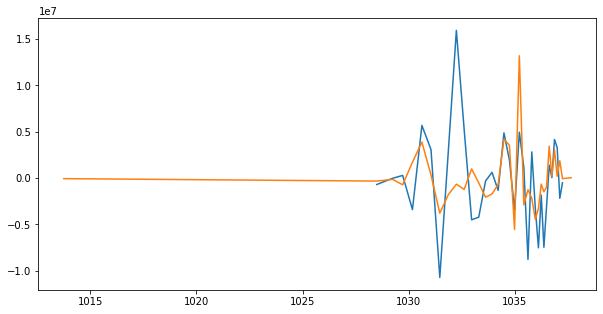

In [9]:
# dE should be equal to the sum of the advective and vertical remap tendencies of o2
LHS = -1*E['dE']#prof['o2h_tendency']
RHS = xr.zeros_like(prof['jo2'])
for term in o2_terms[1:3]:
    RHS += prof[term]
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(LHS['l_l'],LHS)
ax.plot(RHS['l_l'],RHS)
#ax.set_xlim([1028, 1038])

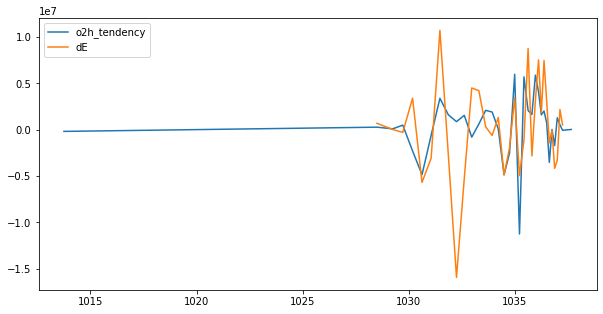

In [12]:
fig,ax = plt.subplots(figsize=(10,5))
signs = [-1,0,0,1,1,1]
count=0
for term in o2_terms[0:1]:
    ax.plot(prof['l_l'],signs[count]*prof[term],label=term)
    count+=1
ax.plot(E['l_l'],E['dE'],label='dE')
ax.legend()
# ax.set_xlim([1028, 1038])

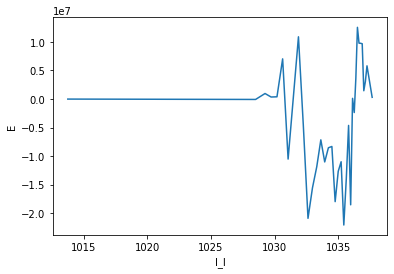

In [13]:
E.E.plot()

### Attempt using jbusecke's regrid/remap functions

In [14]:
# JBusecke xarray utils
# from xarrayutils import vertical_coordinates as vc
# rootdir = '/archive/gam/ESM4/DECK/ESM4_piControl_D/gfdl.ncrc4-intel16-prod-openmp/'
# runname = '6'
# filename = '08990101.ocean_month.nc'
# ds = xr.open_dataset(rootdir+runname+'/history/'+filename)
# Take a subset
ds_now = ds.copy()

# Get the depth of the layers on the native grid
z_i = xr.concat([xr.zeros_like(ds_now['thkcello'].isel(zl=0)),ds_now['thkcello'].cumsum(dim='zl')],dim='zl')
z_i = z_i.rename({'zl':'zi'})
z_i_vals = z_i.values
z_l_vals = 0.5*(z_i_vals[:,:,:-1]+z_i_vals[:,:,1:])
z_l = xr.DataArray(z_l_vals,dims=['yh','xh','zl'],coords={'xh':z_i.xh,'yh':z_i.yh,'zl':ds_now.zl})

ds_now['depth_i']=z_i
ds_now['depth_l']=z_l

In [15]:
l_i_vals = np.append(rho2_i.values,ds_now['rhopot2'].max(xr.ALL_DIMS).values)
E_b = calc_E(ds_now,l=l,l_i_vals=l_i_vals,dl=dl,c=c,area=grid.areacello,binning='busecke')

/nbhome/gam/miniconda/envs/mom6/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:610: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


In [ ]:
# Bin the advective tendency sum in the same manner
c_advection = ds_now['o2_advection_xy']+ds_now['o2h_tendency_vert_remap']
c_advection_remap = vc.conservative_remap(c_advection,z_bnds_source=ds_now['depth_i'], z_bnds_target=E['l_depth_i'],
                                   z_dim='zl', z_bnd_dim='zi', z_bnd_dim_target='regridded', mask=True)
c_advection_int = (c_advection_remap*grid.areacello).sum(dim=['xh','yh'])

(1028, 1038)

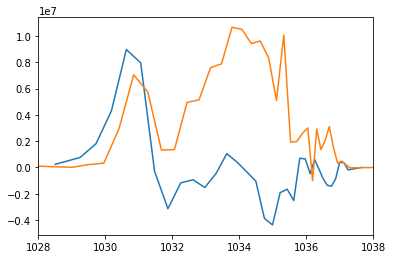

In [22]:
plt.plot(E['l_l'],-1*E['dE'])
plt.plot(l_i_vals[1:],c_advection_int)
plt.gca().set_xlim([1028,1038])

In [16]:
ds_advection = vc.conservative_remap(ds_now['o2_advection_xy'],z_bnds_source=ds_now['depth_i'], z_bnds_target=E_b['l_depth_i'],
                                   z_dim='zl', z_bnd_dim='zi', z_bnd_dim_target='regridded', mask=True)
prof_advection = (ds_advection*grid.areacello).sum(dim=['xh','yh'])

(1028, 1038)

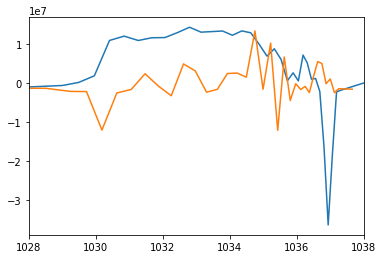

In [33]:
plt.plot(l_i_vals[:-1],prof_advection)
plt.plot(prof['l_l'],prof['o2_advection_xy'])
plt.gca().set_xlim([1028, 1038])

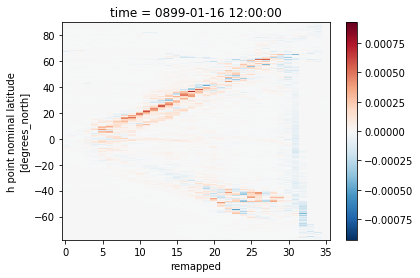

In [37]:
ds_advection.sum('xh').plot()